## This code is to read from the corpus of lines that have English and Spanish lines
(Source: http://www.manythings.org/anki/ spa-eng.zip)

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import re
import string

# Visualization library
import seaborn as sns
import matplotlib.pyplot as plt

# NLP library
from nltk.tokenize import word_tokenize


In [2]:
#Ensuring same seed for future replication
from numpy.random import seed
seed(42)

In [3]:
#Reading lines from the Spanish - English text file
lines= pd.read_table('spa.txt', names=['eng'])

In [4]:
#Looking at sample lines
lines.head()

eng
Go. Ve.      CC-BY 2.0 (France) Attribution: tatoeba.org #2...
    Vete.    CC-BY 2.0 (France) Attribution: tatoeba.org #2...
    Vaya.    CC-BY 2.0 (France) Attribution: tatoeba.org #2...
    Váyase.  CC-BY 2.0 (France) Attribution: tatoeba.org #2...
Hi. Hola.    CC-BY 2.0 (France) Attribution: tatoeba.org #5...

In [5]:
#See how many rows we have
lines.shape

(128084, 1)

In [6]:
#Check for nulls
lines.isnull().sum()

eng    0
dtype: int64

## English word seems to have gone into index, column names need to be adjusted

In [8]:
#Remove english word as index into main column and dropping source of the line as a column
lines.reset_index(inplace=True)
lines.columns=['eng', 'spa', 'misc']
lines.drop(columns=['misc', 'spa'], inplace=True)

In [9]:
lines.head()

,eng
0,Go.
1,Go.
2,Go.
3,Go.
4,Hi.


## Data Cleansing so that it can be worked upon later

In [10]:
# Lowercase all characters
lines['eng']=lines['eng'].apply(lambda x: x.lower())

# Remove quotes, inverted question marks from Spanish
lines['eng']=lines['eng'].apply(lambda x: re.sub("'", '', x))

# Remove all the special characters
exclude = set(string.punctuation) # Set of all special characters

lines['eng']=lines['eng'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

# Remove all numbers from text
remove_digits = str.maketrans('', '', string.digits)
lines['eng']=lines['eng'].apply(lambda x: x.translate(remove_digits))

# Remove extra spaces
lines['eng']=lines['eng'].apply(lambda x: x.strip())

lines['eng']=lines['eng'].apply(lambda x: re.sub(" +", " ", x))

# Add start and end tokens to target sequences
#lines['spa']=lines['spa'].apply(lambda x : 'START_ '+ x + ' _END')

In [11]:
#Review sample lines from english
lines[['eng']][100:110]

,eng
100,no way
101,no way
102,no way
103,really
104,really
105,thanks
106,thanks
107,try it
108,we ate
109,we try


In [14]:
# Moving into df dataframe and doing some EDA
df = lines[['eng']]

# Calculating the length of each line of dialogue
df['eng_len'] = df['eng'].apply(lambda x: len(x))

In [16]:
#Step 2 is to create new columns of number of words and count of characters in the 3 text columns.
def word_len_count(column):
    word_count = len(column.split())
    return word_count

df['word_count'] = df['eng'].apply(word_len_count)

In [17]:
df.head()

,eng,eng_len,word_count
0,go,2,1
1,go,2,1
2,go,2,1
3,go,2,1
4,hi,2,1


## Let's find duplicate English words and remove them from the corpus.  This is because we have to later limit how many lines can be used to build the corpus.  So even though same English words may have different Spanish words and meanings, we can get more distinct words in our corpus.

In [18]:
# Find duplicate rows for sentences in English
duplicateEngRow = df[df.duplicated(['eng'])]
print(duplicateEngRow.shape)

(19226, 3)


## There are about 19k duplicate English lines, let us remove these from the overall 128k lines in the text file

In [19]:
#Creating deduped dataframe dropping English duplicates to create dfd (df-deduped)
#Source https://stackoverflow.com/questions/44546086/remove-one-dataframe-from-another-with-pandas
dfd = pd.merge(df, duplicateEngRow, how='outer', indicator=True).query("_merge != 'both'").drop('_merge', axis=1).reset_index(drop=True)

In [20]:
#Checking shape - confirms that we dropped ~19k rows
dfd.shape

(94605, 3)

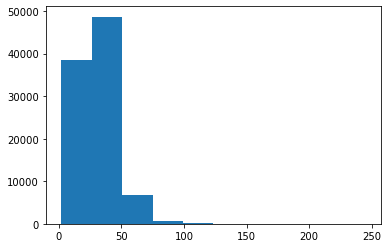

In [21]:
#Checking histogram of English character counts
plt.hist(dfd['eng_len']);

## There are a lot of tails, clipping off at 50 character count at high end will help to keep vectors manageable for each line

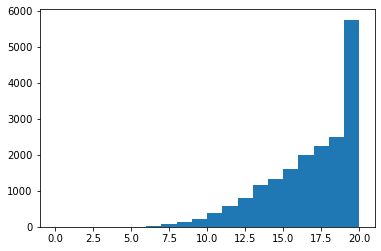

In [22]:
#Checking histogram of English character counts at lower end
plt.hist(dfd['eng_len'], range(0, 21));

In [24]:
# Saving dataframe with dialogue length less than 50 characters and more than 18 characters from the EDA above
dfd = dfd[dfd['eng_len']< 50]
dfd = dfd[dfd['eng_len']> 18]

data = dfd.values.tolist()

# Examining the first 5 rows
data[:5]

[['a dog has four legs', 19, 5],
 ['a lion is an animal', 19, 5],
 ['a noise woke her up', 19, 5],
 ['a nurse wears white', 19, 4],
 ['a truck hit the dog', 19, 5]]

In [25]:
# Clipping for shorter and longer lines, we are at 83k lines
len(data)

73209

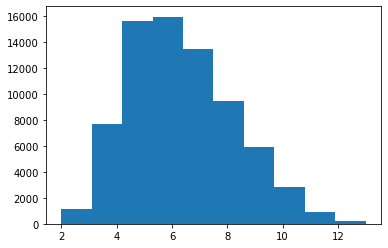

In [26]:
#Checking histogram of English character counts
plt.hist(dfd['word_count']);

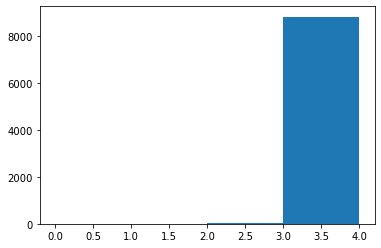

In [27]:
#Checking histogram of English character counts at lower end
plt.hist(dfd['word_count'], range(0, 5));

In [28]:
# Saving dataframe with word count higher than 3 from EDA above
dfd = dfd[dfd['word_count']> 3]

data = dfd.values.tolist()

# Examining the first 5 rows
data[:5]

[['a dog has four legs', 19, 5],
 ['a lion is an animal', 19, 5],
 ['a noise woke her up', 19, 5],
 ['a nurse wears white', 19, 4],
 ['a truck hit the dog', 19, 5]]

In [31]:
dfd.shape

(72080, 3)

In [46]:
#Step is to create pre and post columns to train sentence completion
def line_split_pre(column):
    line_pre = (column.split())[:-2]
    line_pre_joined = ' '.join(line_pre)
    return line_pre_joined

In [57]:
def line_split_post(column):
    line_post = (column.split())[3:]
    line_post_joined = ' '.join(line_post)
    return line_post_joined

In [58]:
dfd['eng_pre'] = dfd['eng'].apply(line_split_pre)
dfd['eng_post'] = dfd['eng'].apply(line_split_post)

In [59]:
dfd.head()

,eng,eng_len,word_count,eng_pre,eng_post
12267,a dog has four legs,19,5,a dog has,four legs
12268,a lion is an animal,19,5,a lion is,an animal
12269,a noise woke her up,19,5,a noise woke,her up
12270,a nurse wears white,19,4,a nurse,white
12271,a truck hit the dog,19,5,a truck hit,the dog


In [60]:
dfd.shape

(72080, 5)

In [61]:
#Write to csv so it can be used for continuous training later
dfd.to_csv('./data/eng.csv')